In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

Train shape: (1903994, 6)
Test shape: (28512, 5)
Stores shape: (54, 5)
Oil shape: (1218, 2)
Holidays shape: (350, 6)
Oil dataset columns: ['date', 'dcoilwtico']


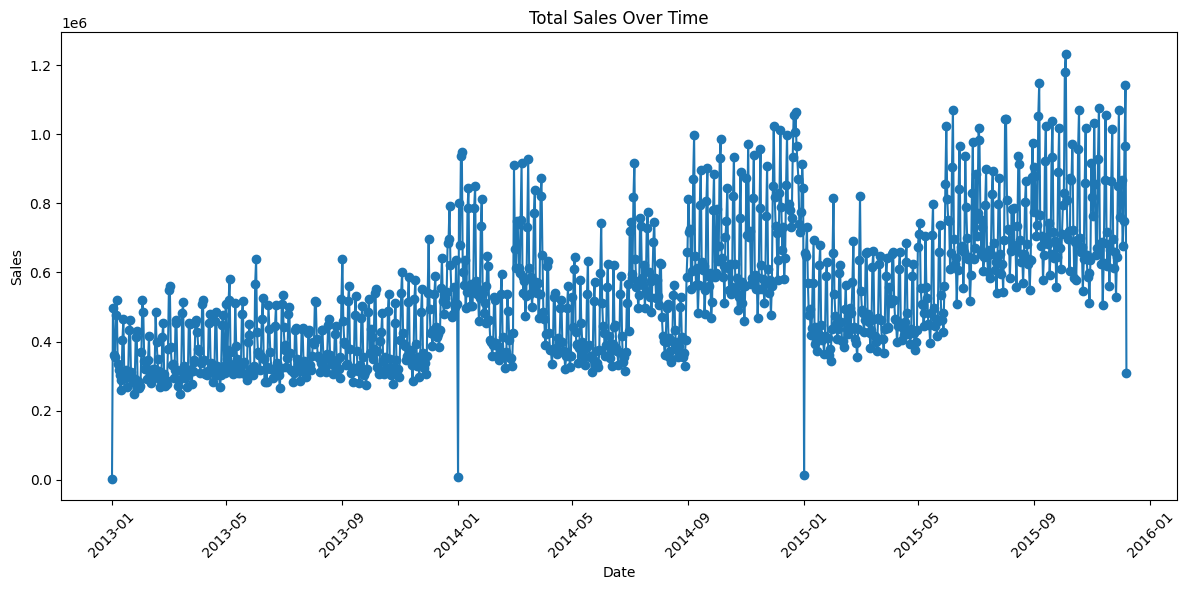

Training set shape: (1878228, 21)
Validation set shape: (25766, 21)
Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 243.865	valid_1's rmse: 359.816
[200]	training's rmse: 211.099	valid_1's rmse: 339.664
[300]	training's rmse: 193.727	valid_1's rmse: 332.791
[400]	training's rmse: 183.088	valid_1's rmse: 327.994
[500]	training's rmse: 175.347	valid_1's rmse: 324.589
[600]	training's rmse: 168.896	valid_1's rmse: 322.046
[700]	training's rmse: 163.775	valid_1's rmse: 317.506
[800]	training's rmse: 159.4	valid_1's rmse: 316.06
Early stopping, best iteration is:
[778]	training's rmse: 160.238	valid_1's rmse: 315.91
Validation RMSLE: 0.9867136531896002


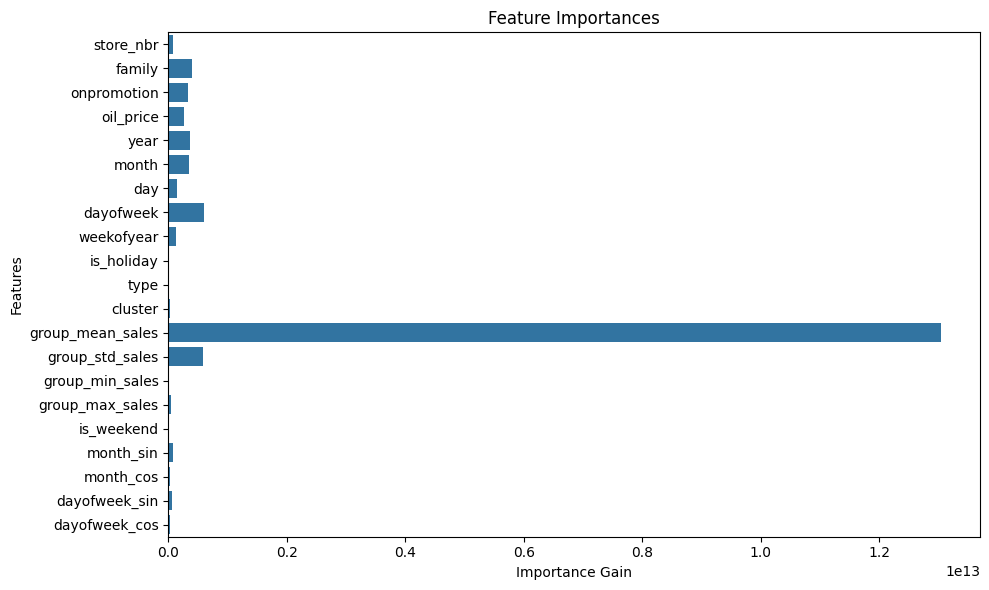

Submission file 'submission.csv' created!


6687

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Set display options and random seed for reproducibility
pd.set_option('display.max_columns', None)
np.random.seed(42)

#############################################
# 1. Data Loading
#############################################

# Load datasets
train = pd.read_csv('/content/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/test.csv', parse_dates=['date'])
stores = pd.read_csv('/content/stores.csv')
oil = pd.read_csv('/content/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/content/holidays_events.csv', parse_dates=['date'])

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Stores shape:", stores.shape)
print("Oil shape:", oil.shape)
print("Holidays shape:", holidays.shape)

#############################################
# 2. Data Preprocessing and Feature Engineering
#############################################

# Merge oil data on 'date' and rename 'dcoilwtico' to 'oil_price'
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')
print("Oil dataset columns:", oil.columns.tolist())
train.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
test.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

# Merge store metadata
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

# Create holiday flag: mark a day as holiday if it is in holidays_events (and not a transferred holiday)
holiday_dates = holidays.loc[holidays['transferred'] == False, 'date'].unique()
train['is_holiday'] = train['date'].isin(holiday_dates).astype(int)
test['is_holiday'] = test['date'].isin(holiday_dates).astype(int)

# Create date features
def create_date_features(df):
    df['year']      = df['date'].dt.year
    df['month']     = df['date'].dt.month
    df['day']       = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['weekofyear']= df['date'].dt.isocalendar().week.astype(int)
    return df

train = create_date_features(train)
test = create_date_features(test)

# Fill missing oil_price values using forward fill
train['oil_price'] = train['oil_price'].ffill()
test['oil_price']  = test['oil_price'].ffill()

#############################################
# 3. Additional Feature Engineering
#############################################

# Group-level statistics per (store_nbr, family) computed from training data
group_stats = train.groupby(['store_nbr', 'family'])['sales'].agg(['mean', 'std', 'min', 'max']).reset_index()
group_stats.rename(columns={'mean': 'group_mean_sales',
                            'std': 'group_std_sales',
                            'min': 'group_min_sales',
                            'max': 'group_max_sales'}, inplace=True)
# Merge these stats into both train and test datasets
train = train.merge(group_stats, on=['store_nbr', 'family'], how='left')
test  = test.merge(group_stats, on=['store_nbr', 'family'], how='left')

# Create a binary weekend indicator (1 if Saturday or Sunday)
train['is_weekend'] = train['dayofweek'].isin([5,6]).astype(int)
test['is_weekend']  = test['dayofweek'].isin([5,6]).astype(int)

# Create cyclical features for month and dayofweek (to capture seasonality)
train['month_sin']      = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos']      = np.cos(2 * np.pi * train['month'] / 12)
train['dayofweek_sin']  = np.sin(2 * np.pi * train['dayofweek'] / 7)
train['dayofweek_cos']  = np.cos(2 * np.pi * train['dayofweek'] / 7)
test['month_sin']       = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos']       = np.cos(2 * np.pi * test['month'] / 12)
test['dayofweek_sin']   = np.sin(2 * np.pi * test['dayofweek'] / 7)
test['dayofweek_cos']   = np.cos(2 * np.pi * test['dayofweek'] / 7)

#############################################
# 4. Categorical Encoding & Feature List Setup
#############################################
from sklearn.preprocessing import LabelEncoder
# Label encode categorical features.
# (Perform this after group-level features are merged so group_stats remain intact.)
#from sklearn.preprocessing import LabelEncoder

for col in ['family', 'type', 'cluster']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col]  = le.transform(test[col].astype(str))

# Define features to be used in modeling (including our new features)
features = [
    'store_nbr', 'family', 'onpromotion', 'oil_price', 'year',
    'month', 'day', 'dayofweek', 'weekofyear', 'is_holiday', 'type', 'cluster',
    'group_mean_sales', 'group_std_sales', 'group_min_sales', 'group_max_sales',
    'is_weekend', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos'
]

# Prepare training data (target is 'sales')
X_all = train[features]
y_all = train['sales']

# Prepare test data
X_test = test[features]

#############################################
# 5. Exploratory Data Analysis (EDA)
#############################################

# Plot overall sales over time (aggregated by date)
sales_by_date = train.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(sales_by_date['date'], sales_by_date['sales'], marker='o', linestyle='-')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#############################################
# 6. Time-based Train/Validation Split
#############################################

# Instead of a random split, use a time-based split.
# For instance, let the last 15 days of training be the validation set.
max_date = train['date'].max()
val_cutoff = max_date - pd.Timedelta(days=15)

X_train = train.loc[train['date'] <= val_cutoff, features]
y_train = train.loc[train['date'] <= val_cutoff, 'sales']
X_val   = train.loc[train['date'] >  val_cutoff, features]
y_val   = train.loc[train['date'] >  val_cutoff, 'sales']

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

#############################################
# 7. Model Training using LightGBM
#############################################

# Define RMSLE (Root Mean Squared Logarithmic Error)
import numpy as np
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
import numpy as np
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_val, y_val, reference=lgb_train)

# Set model parameters (baseline configuration)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

print("Training LightGBM model...")
# Train model with callbacks for early stopping and logging
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=1000,
                  valid_sets=[lgb_train, lgb_eval],
                  callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=100)])

# Predict on the validation set; clip negatives to zero (RMSLE requires non-negative predictions)
val_preds = model.predict(X_val, num_iteration=model.best_iteration)
val_preds = np.maximum(0, val_preds)
val_score = rmsle(y_val, val_preds)
print("Validation RMSLE:", val_score)

#############################################
# 8. Feature Importance Visualization
#############################################

importances = model.feature_importance(importance_type='gain')
feature_names = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance Gain')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#############################################
# 9. Predicting on Test Data and Creating Submission File
#############################################

# Generate predictions on the test set and clip negative values to zero
test_preds = model.predict(X_test, num_iteration=model.best_iteration)
test_preds = np.maximum(0, test_preds)

# Create submission file; ensure test set has an 'id' column
submission = pd.DataFrame({
    'id': test['id'],   # Make sure your test.csv includes the 'id' column
    'sales': test_preds
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created!")

#############################################
# 10. Cleanup and Final Remarks
#############################################

del X_train, X_val, y_train, y_val, lgb_train, lgb_eval
gc.collect()